In [112]:
import cv2
import numpy as np
import os
import glob
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import  Conv1D, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt
import keras
import keras.callbacks as KC

cat_dir = 'clean_images/cat_images/'
dog_dir = 'clean_images/dog_images/'
SIZE = 64 #100から変更
TRAIN_RATIO = 0.8
RESHAPED = 0
NB_CLASSES = 2
OPTIMIZER = SGD()
BATCH_SIZE = 131
NB_EPOCH = 100
VALIDATION_SPLIT = 0.4
VERBOSE = 1
SAVED_MODEL_PATH = 'models/cat_dog_classfication_aug_gray_model.hdf5'
COLOR_MODE = 0
USE_DATAGEN = True

def prepare_data():
    # 猫(0)と犬(1)の画像を取得してフラグを追加したにシャッフル加工してデータとして返す。
    
    images = []
    cat_answers = []
    dog_answers = []
    cat_images = []
    dog_images = []
    validation_images = []
    validation_answers = []

    cat_files = glob.glob(os.path.join(cat_dir, '*.jpg'))
    cat_files.sort()
    dog_files = glob.glob(os.path.join(dog_dir, '*.jpg'))
    dog_files.sort()

    for cat_image in cat_files:
        if cat_image.endswith('.jpg'):
            cat_images.append(resize_for_model(cv2.imread(cat_image, COLOR_MODE)))
            cat_answers.append(0)

    for dog_image in dog_files:
        if dog_image.endswith('.jpg'):
            dog_images.append(resize_for_model(cv2.imread(dog_image, COLOR_MODE)))
            dog_answers.append(1)

    test_border_cat = int(len(cat_images) * (1 - TRAIN_RATIO))
    test_border_dog = int(len(dog_images) * (1 - TRAIN_RATIO))
    
    test_images = np.array(cat_images[:test_border_cat] + dog_images[:test_border_dog])
    test_answers = np.array(cat_answers[:test_border_cat] + dog_answers[:test_border_dog])
            
    validation_border_cat = test_border_cat + int(len(cat_images) * TRAIN_RATIO * VALIDATION_SPLIT)
    validation_border_dog = test_border_dog + int(len(dog_images) * TRAIN_RATIO * VALIDATION_SPLIT)

    validation_images = np.array(cat_images[test_border_cat:test_border_cat + validation_border_cat] + dog_images[test_border_dog:validation_border_dog])
    validation_answers = np.array(cat_answers[test_border_cat:test_border_cat + validation_border_cat] + dog_answers[test_border_dog:validation_border_dog])
    train_images = np.array(cat_images[validation_border_cat:] + dog_images[validation_border_dog:])
    train_answers = np.array(cat_answers[validation_border_cat:] + dog_answers[validation_border_dog:])

    # imagesとanswersの関係保ったままシャッフル
    data = []
    for images, answers in ((train_images, train_answers), (validation_images, validation_answers), (test_images, test_answers)):
        random_idxs = np.random.permutation(len(images))
        images = images[random_idxs]
        answers = answers[random_idxs]
        data.append([images, answers])
    
    return (data[0][0], data[0][1]), (data[1][0], data[1][1]), (data[2][0], data[2][1])

def resize_for_model(image):
    # np形式のimageを特定の大きさにresizeする。
    return cv2.resize(image, (SIZE, SIZE))

def remove_log_files(dir):
    files = glob.glob(os.path.join(dir, '*.local'))
    for file in files:
        os.remove(file)
    

if __name__ == '__main__':
    (X_train, y_train),(X_valid, y_valid), (X_test, y_test) = prepare_data()
    print(len(X_train), 'X_train amount')
    print(len(X_valid), 'X_valid amount')    
    print(len(X_test), 'X_test amount')
    print(X_train.shape, 'X_train shape')
    print(X_valid.shape, 'X_valid shape')    
    print(X_test.shape, 'X_test shape')
    if len(X_train.shape) > 3:
        SHAPE = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    else:
        SHAPE = (X_train.shape[1], X_train.shape[2], 1)
    print(SHAPE, 'shape')

131 X_train amount
111 X_valid amount
53 X_test amount
(131, 64, 64) X_train shape
(111, 64, 64) X_valid shape
(53, 64, 64) X_test shape
(64, 64, 1) shape


In [113]:
if SHAPE[2] == 1:
    X_train = X_train.reshape(X_train.shape[0],  SIZE, SIZE, 1)
    X_valid = X_valid.reshape(X_valid.shape[0],  SIZE, SIZE, 1)
    X_test = X_test.reshape(X_test.shape[0],  SIZE, SIZE, 1)


X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_valid /= 255
X_test /= 255

In [114]:
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_valid = np_utils.to_categorical(y_valid, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)


In [115]:
callbacks = [KC.TensorBoard()
                     ,KC.ModelCheckpoint(filepath=SAVED_MODEL_PATH,
                                                           verbose=1,
                                                           save_weights_only=True,
                                                           save_best_only=True,
                                                           period=10)]

In [116]:
from keras.preprocessing.image  import ImageDataGenerator

if USE_DATAGEN:
    datagen = ImageDataGenerator(featurewise_center=True,
                                                            featurewise_std_normalization=True,
                                                            rotation_range=20,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            horizontal_flip=True)

    datagen.fit(X_train)

In [117]:
#参考: https://keras.io/getting-started/sequential-model-guide/
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors. 64の方が良さげ
FILTERS = 16
# with 3 channels
model.add(Conv2D(FILTERS, (3, 3), activation='relu', input_shape=SHAPE))
model.add(Conv2D(FILTERS, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

#この層無い方がマシっぽい
# model.add(Conv2D(UNITS * 2, (3, 3), activation='relu'))
# model.add(Conv2D(UNITS * 2, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.6)) #無い方が良い
model.add(Dense(NB_CLASSES, activation='softmax'))

In [118]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

In [119]:
remove_log_files('logs/')
if USE_DATAGEN:
    history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE), epochs=NB_EPOCH * 4, verbose=VERBOSE, validation_data=(X_valid, Y_valid), shuffle=True, callbacks=callbacks, steps_per_epoch=1)
else:
    history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH * 4, verbose=VERBOSE, validation_data=(X_valid, Y_valid), shuffle=True, callbacks=callbacks)

Epoch 1/400
1/1 [==============================] - 1s 992ms/step - loss: 0.7122 - acc: 0.4962 - val_loss: 0.7044 - val_acc: 0.3604
Epoch 2/400
1/1 [==============================] - 0s 439ms/step - loss: 0.6951 - acc: 0.5038 - val_loss: 0.6974 - val_acc: 0.4324
Epoch 3/400
1/1 [==============================] - 0s 440ms/step - loss: 0.6973 - acc: 0.5267 - val_loss: 0.6936 - val_acc: 0.4775
Epoch 4/400
1/1 [==============================] - 1s 513ms/step - loss: 0.7012 - acc: 0.4504 - val_loss: 0.6917 - val_acc: 0.5495
Epoch 5/400
1/1 [==============================] - 1s 501ms/step - loss: 0.7041 - acc: 0.4809 - val_loss: 0.6915 - val_acc: 0.5676
Epoch 6/400
1/1 [==============================] - 0s 488ms/step - loss: 0.7023 - acc: 0.4809 - val_loss: 0.6921 - val_acc: 0.5405
Epoch 7/400
1/1 [==============================] - 1s 514ms/step - loss: 0.6930 - acc: 0.5115 - val_loss: 0.6928 - val_acc: 0.5405
Epoch 8/400
1/1 [==============================] - 0s 485ms/step - loss: 0.6946 - a

Epoch 59/400
1/1 [==============================] - 0s 433ms/step - loss: 0.6506 - acc: 0.6336 - val_loss: 0.6701 - val_acc: 0.5946
Epoch 60/400
1/1 [==============================] - 0s 469ms/step - loss: 0.6308 - acc: 0.6489 - val_loss: 0.6701 - val_acc: 0.5856

Epoch 00060: val_loss improved from 0.67094 to 0.67011, saving model to models/cat_dog_classfication_aug_gray_model.hdf5
Epoch 61/400
1/1 [==============================] - 0s 421ms/step - loss: 0.6443 - acc: 0.5878 - val_loss: 0.6699 - val_acc: 0.5856
Epoch 62/400
1/1 [==============================] - 0s 433ms/step - loss: 0.6237 - acc: 0.6336 - val_loss: 0.6690 - val_acc: 0.5946
Epoch 63/400
1/1 [==============================] - 0s 444ms/step - loss: 0.6425 - acc: 0.5878 - val_loss: 0.6679 - val_acc: 0.5946
Epoch 64/400
1/1 [==============================] - 0s 431ms/step - loss: 0.6375 - acc: 0.6641 - val_loss: 0.6667 - val_acc: 0.6036
Epoch 65/400
1/1 [==============================] - 0s 432ms/step - loss: 0.6382 - acc

Epoch 117/400
1/1 [==============================] - 0s 445ms/step - loss: 0.6127 - acc: 0.6718 - val_loss: 0.6638 - val_acc: 0.6126
Epoch 118/400
1/1 [==============================] - 0s 436ms/step - loss: 0.6183 - acc: 0.6947 - val_loss: 0.6635 - val_acc: 0.6306
Epoch 119/400
1/1 [==============================] - 0s 443ms/step - loss: 0.6154 - acc: 0.6336 - val_loss: 0.6627 - val_acc: 0.6216
Epoch 120/400
1/1 [==============================] - 0s 467ms/step - loss: 0.6335 - acc: 0.6641 - val_loss: 0.6614 - val_acc: 0.5946

Epoch 00120: val_loss improved from 0.66200 to 0.66138, saving model to models/cat_dog_classfication_aug_gray_model.hdf5
Epoch 121/400
1/1 [==============================] - 0s 451ms/step - loss: 0.6035 - acc: 0.7023 - val_loss: 0.6605 - val_acc: 0.6036
Epoch 122/400
1/1 [==============================] - 0s 443ms/step - loss: 0.6364 - acc: 0.6031 - val_loss: 0.6600 - val_acc: 0.6126
Epoch 123/400
1/1 [==============================] - 0s 467ms/step - loss: 0.624

Epoch 176/400
1/1 [==============================] - 1s 501ms/step - loss: 0.5869 - acc: 0.7023 - val_loss: 0.6611 - val_acc: 0.5856
Epoch 177/400
1/1 [==============================] - 0s 484ms/step - loss: 0.6283 - acc: 0.6489 - val_loss: 0.6611 - val_acc: 0.5946
Epoch 178/400
1/1 [==============================] - 0s 457ms/step - loss: 0.5982 - acc: 0.6870 - val_loss: 0.6614 - val_acc: 0.5946
Epoch 179/400
1/1 [==============================] - 0s 470ms/step - loss: 0.5676 - acc: 0.7023 - val_loss: 0.6623 - val_acc: 0.5946
Epoch 180/400
1/1 [==============================] - 0s 458ms/step - loss: 0.6196 - acc: 0.6260 - val_loss: 0.6633 - val_acc: 0.5856

Epoch 00180: val_loss did not improve from 0.66039
Epoch 181/400
1/1 [==============================] - 0s 441ms/step - loss: 0.6382 - acc: 0.6718 - val_loss: 0.6644 - val_acc: 0.5766
Epoch 182/400
1/1 [==============================] - 0s 455ms/step - loss: 0.6185 - acc: 0.7023 - val_loss: 0.6649 - val_acc: 0.5856
Epoch 183/400
1/1

Epoch 235/400
1/1 [==============================] - 0s 439ms/step - loss: 0.6457 - acc: 0.6565 - val_loss: 0.6646 - val_acc: 0.5766
Epoch 236/400
1/1 [==============================] - 0s 450ms/step - loss: 0.6325 - acc: 0.6489 - val_loss: 0.6645 - val_acc: 0.5766
Epoch 237/400
1/1 [==============================] - 0s 486ms/step - loss: 0.5663 - acc: 0.7328 - val_loss: 0.6640 - val_acc: 0.5856
Epoch 238/400
1/1 [==============================] - 0s 482ms/step - loss: 0.5942 - acc: 0.7023 - val_loss: 0.6631 - val_acc: 0.5946
Epoch 239/400
1/1 [==============================] - 0s 455ms/step - loss: 0.5732 - acc: 0.7176 - val_loss: 0.6626 - val_acc: 0.5946
Epoch 240/400
1/1 [==============================] - 0s 431ms/step - loss: 0.5805 - acc: 0.7405 - val_loss: 0.6623 - val_acc: 0.5946

Epoch 00240: val_loss did not improve from 0.65876
Epoch 241/400
1/1 [==============================] - 0s 430ms/step - loss: 0.6097 - acc: 0.6947 - val_loss: 0.6621 - val_acc: 0.5946
Epoch 242/400
1/1

Epoch 294/400
1/1 [==============================] - 0s 475ms/step - loss: 0.5664 - acc: 0.7176 - val_loss: 0.6612 - val_acc: 0.5946
Epoch 295/400
1/1 [==============================] - 0s 449ms/step - loss: 0.6034 - acc: 0.6870 - val_loss: 0.6618 - val_acc: 0.5766
Epoch 296/400
1/1 [==============================] - 0s 475ms/step - loss: 0.6002 - acc: 0.7328 - val_loss: 0.6619 - val_acc: 0.5766
Epoch 297/400
1/1 [==============================] - 0s 473ms/step - loss: 0.5718 - acc: 0.7328 - val_loss: 0.6617 - val_acc: 0.5856
Epoch 298/400
1/1 [==============================] - 0s 484ms/step - loss: 0.6280 - acc: 0.5954 - val_loss: 0.6615 - val_acc: 0.5856
Epoch 299/400
1/1 [==============================] - 0s 455ms/step - loss: 0.5864 - acc: 0.7176 - val_loss: 0.6614 - val_acc: 0.5946
Epoch 300/400
1/1 [==============================] - 0s 458ms/step - loss: 0.5737 - acc: 0.6794 - val_loss: 0.6614 - val_acc: 0.5946

Epoch 00300: val_loss did not improve from 0.65865
Epoch 301/400
1/1

Epoch 354/400
1/1 [==============================] - 0s 478ms/step - loss: 0.5585 - acc: 0.7176 - val_loss: 0.6617 - val_acc: 0.5856
Epoch 355/400
1/1 [==============================] - 0s 475ms/step - loss: 0.6567 - acc: 0.6336 - val_loss: 0.6621 - val_acc: 0.5856
Epoch 356/400
1/1 [==============================] - 0s 453ms/step - loss: 0.5768 - acc: 0.7405 - val_loss: 0.6627 - val_acc: 0.5946
Epoch 357/400
1/1 [==============================] - 0s 462ms/step - loss: 0.5876 - acc: 0.6565 - val_loss: 0.6634 - val_acc: 0.5946
Epoch 358/400
1/1 [==============================] - 0s 468ms/step - loss: 0.5513 - acc: 0.7634 - val_loss: 0.6638 - val_acc: 0.5856
Epoch 359/400
1/1 [==============================] - 1s 556ms/step - loss: 0.5879 - acc: 0.7481 - val_loss: 0.6641 - val_acc: 0.5856
Epoch 360/400
1/1 [==============================] - 0s 460ms/step - loss: 0.6104 - acc: 0.7099 - val_loss: 0.6641 - val_acc: 0.5856

Epoch 00360: val_loss did not improve from 0.65865
Epoch 361/400
1/1

In [120]:
score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print('Test score:', score[0])
print('Test acc:', score[1])

53/53 [==============================] - 0s 1ms/step
Test score: 0.7275596857070923
Test acc: 0.5283018873547608


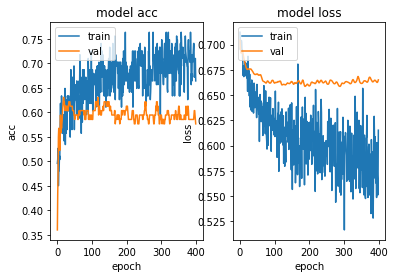

In [121]:
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('chart/aug_gray.png')
plt.show()

train_dataのacc, lossは順調に推移するが、val_dataに対しては一定幅で同水準に留まる。
元データが少ないから？(https://datascience.stackexchange.com/questions/37815/what-to-do-if-training-loss-decreases-but-validation-loss-does-not-decrease)

In [75]:
predict_answers = model.predict_classes(X_test)

TypeError: Invalid dimensions for image data

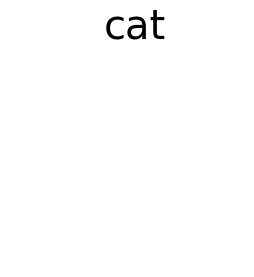

In [76]:
plt.figure(figsize=(50,50))
columns = 5
cat_wrong_cnt = 0
dog_wrong_cnt = 0
for i, image in enumerate(X_test):
    plt.subplot(len(X_test) / columns + 1, columns, i + 1)
    predicted_num = predict_answers[i]
    answer = y_test[i]
    
    if predicted_num != answer:
        if predicted_num == 0:
            label = 'cat'
            cat_wrong_cnt += 1
        else:
            label = 'dog'
            dog_wrong_cnt += 1
        plt.title(label, fontsize=40)
        plt.axis('off')
        plt.imshow(image)

print('answer is dog, but cat is predicted:', cat_wrong_cnt)
print('answer is cat, but dog is predicted:', dog_wrong_cnt)

画像加工 min val-loss, filters, dropout, note<br>
gray 0.69, 16, 0.3, epoch50くらいで過学習<br>
color 0.59, 16, 0.3, epoch180くらいで過学習<br>
aug, 0.61, 16, 0.3, epoch180くらいで過学習<br>
gray & aug<br>